In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import prophet
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset
df = pd.read_csv('C:/Users/Lenovo/Downloads/goldstock.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [3]:
df.shape

(2511, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2511 entries, 2024-01-19 to 2014-01-22
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2511 non-null   int64  
 1   Close       2511 non-null   float64
 2   Volume      2511 non-null   float64
 3   Open        2511 non-null   float64
 4   High        2511 non-null   float64
 5   Low         2511 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 137.3 KB


In [5]:
df.head()

,Unnamed: 0,Close,Volume,Open,High,Low
Date,,,,,,
2024-01-19,0,2029.3,166078.0,2027.4,2041.9,2022.2
2024-01-18,1,2021.6,167013.0,2009.1,2025.6,2007.7
2024-01-17,2,2006.5,245194.0,2031.7,2036.1,2004.6
2024-01-16,3,2030.2,277995.0,2053.4,2062.8,2027.6
2024-01-12,4,2051.6,250946.0,2033.2,2067.3,2033.1


In [6]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

df.shape

(2511, 5)

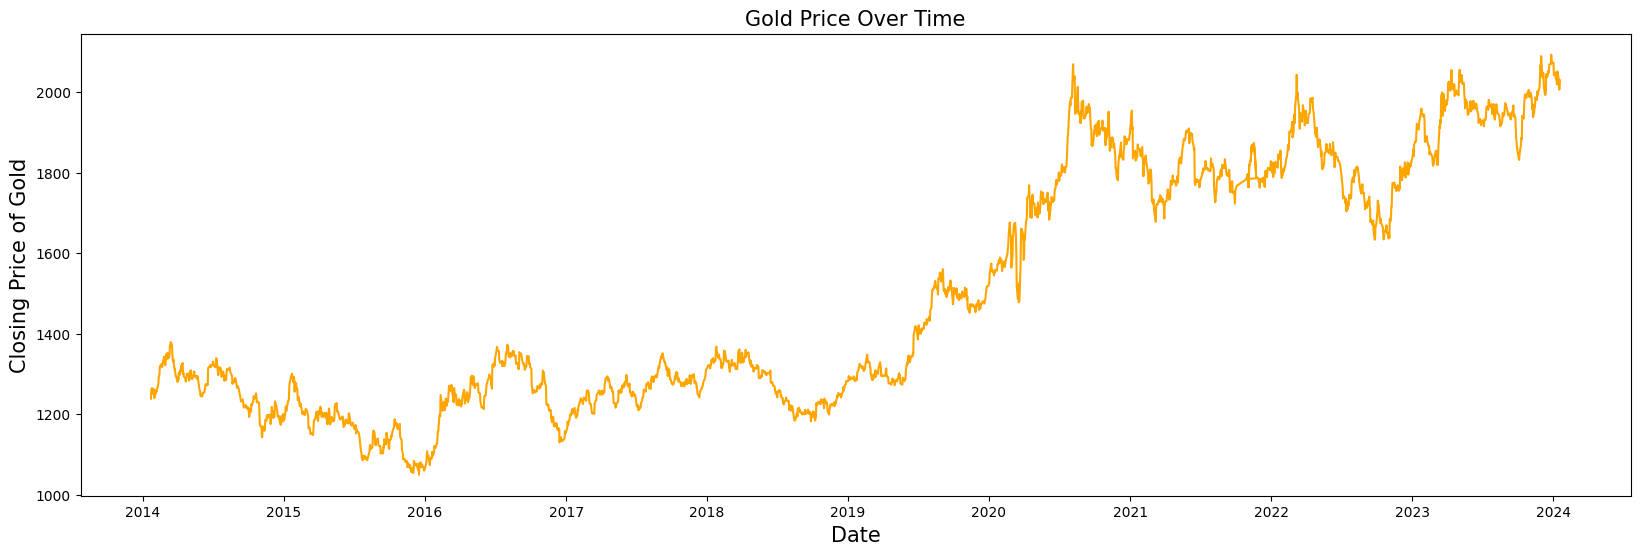

In [7]:
# Time series analysis
plt.figure(figsize=(20, 6))
plt.plot(df['Close'], color='orange')
plt.title('Gold Price Over Time', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Closing Price of Gold', fontsize=15)
plt.show()

<Figure size 2000x600 with 0 Axes>

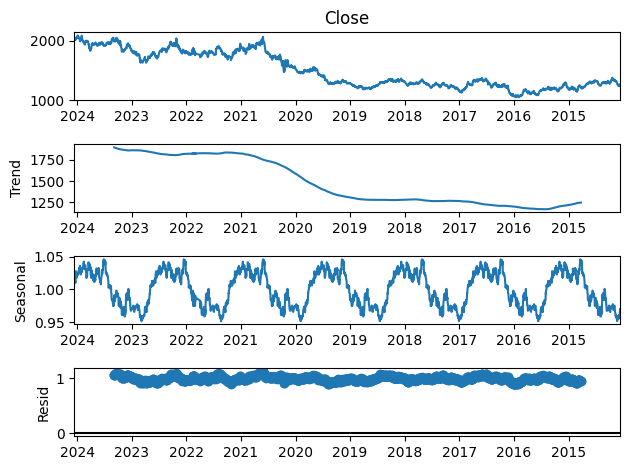

In [8]:
# Seasonal decomposition
plt.figure(figsize=(20, 6))
decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=365)
decomposition.plot()
plt.show()

<Figure size 2000x600 with 0 Axes>

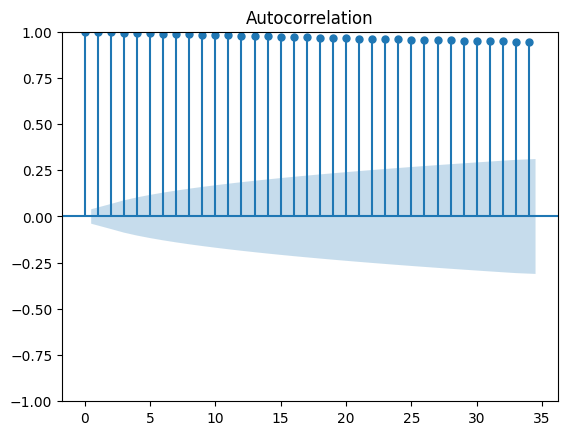

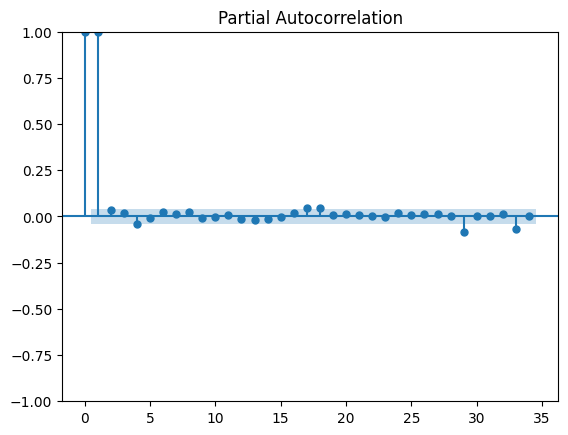

In [9]:
# Autocorrelation and partial autocorrelation plots
plt.figure(figsize=(20,6))
plot_acf(df['Close'])
plt.show()

plot_pacf(df['Close'])
plt.show()

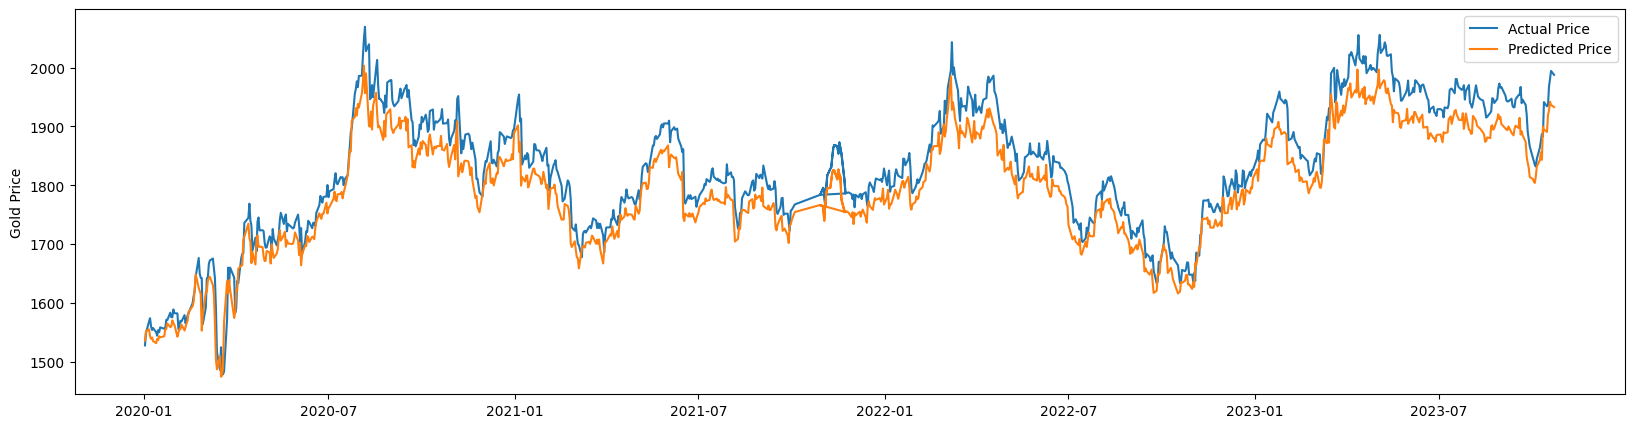

MSE: 1732.4885588891316
R2 Score: 0.8578403465355835
85.78403465355835 %


In [17]:
# Advanced modeling
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# Load the data
df = pd.read_csv('C:/Users/Lenovo/Downloads/goldstock.csv')

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the index to the 'Date' column
df.set_index('Date', inplace=True)

# Split the data into training and testing sets
train_data = df.loc[:'2020-01-01']
test_data = df.loc['2020-01-02':]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(train_data[['Close']])

# Prepare the training data
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=80, batch_size=32, verbose=0)

# Scale the test data
scaled_test_data = scaler.transform(test_data[['Close']])

# Create a sliding window of size 60 over the scaled test data
x_test = []
for i in range(60, len(scaled_test_data)):
    x_test.append(scaled_test_data[i-60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Plot the predictions
plt.figure(figsize=(20, 5))
plt.plot(test_data.index[60:], test_data['Close'][60:], label='Actual Price')
plt.plot(test_data.index[60:], predictions, label='Predicted Price')
plt.legend()
plt.ylabel('Gold Price')
plt.show()

# Evaluate the model
mse = mean_squared_error(test_data['Close'][60:], predictions)
r2 = r2_score(test_data['Close'][60:], predictions)

print('MSE:', mse)
print('R2 Score:', r2)

print(r2*100,'%')

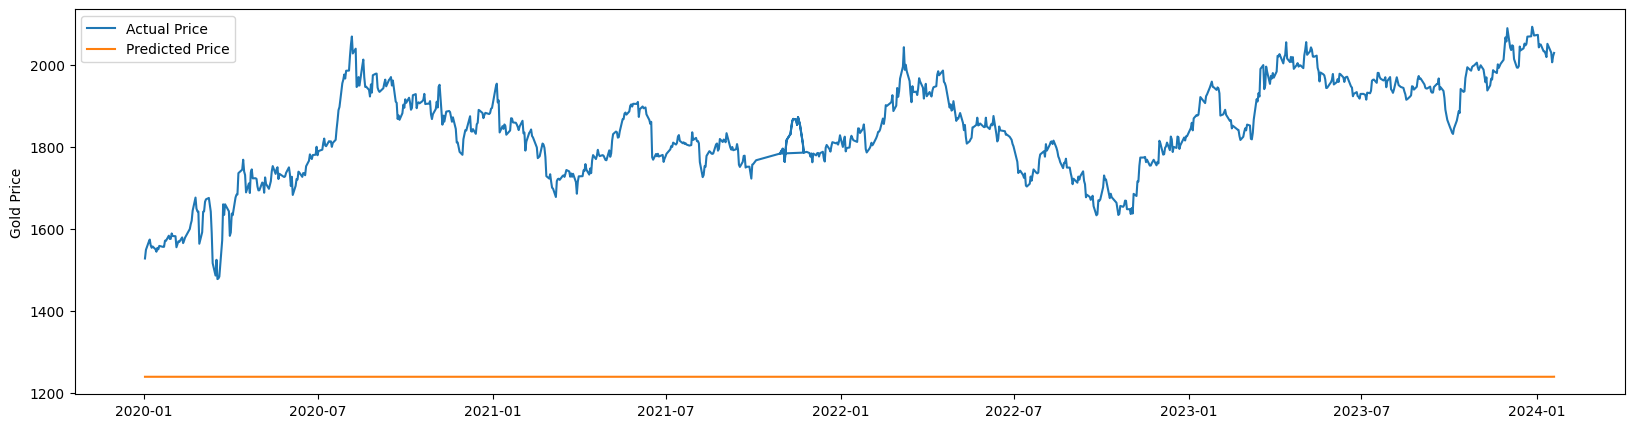

MSE: 372505.4298566179
R2 Score: -26.38798777413012


In [18]:
# ARIMA model
model = ARIMA(train_data['Close'], order=(1, 1, 1))
model_fit = model.fit()

# print("Gold Price =", round(model.coef_[0], 2), "* 2 Month Moving Average", round(
#     model.coef_[1], 2), "* 1 Month Moving Average +", round(model.intercept_, 2))

# Predictions
predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, dynamic=False)

# Plot the predictions
plt.figure(figsize=(20, 5))
plt.plot(test_data.index, test_data['Close'], label='Actual Price')
plt.plot(test_data.index, predictions, label='Predicted Price')
plt.legend()
plt.ylabel('Gold Price')
plt.show()

# Evaluation
mse = mean_squared_error(test_data['Close'], predictions)
r2 = r2_score(test_data['Close'], predictions)

print('MSE:', mse)
print('R2 Score:', r2)

<Figure size 2000x600 with 0 Axes>

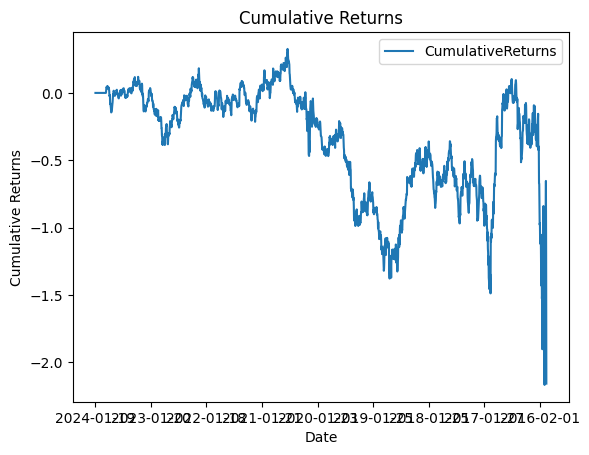

In [12]:
# Trading strategy development
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_csv('C:/Users/Lenovo/Downloads/goldstock.csv')

df['50-day MA'] = df['Close'].rolling(window=50).mean()

# Scale the data
scaler = MinMaxScaler()
df[['Close', '50-day MA']] = scaler.fit_transform(df[['Close', '50-day MA']])

# Buy signal: Close price is below the 50-day moving average
# Sell signal: Close price is above the 50-day moving average
df['Buy Signal'] = np.where(df['Close'] < df['50-day MA'], 1, 0)
df['Sell Signal'] = np.where(df['Close'] > df['50-day MA'], -1, 0)

# Preprocess the data
scaler = StandardScaler()
df['Position'] = df['Buy Signal'] - df['Sell Signal']
df['CumulativeReturns'] = (df['Close'].pct_change() * df['Position']).cumsum()

# Invert the scaling
y_pred_scaled = df['CumulativeReturns'].iloc[-1]

# Check if the cumulative return is infinity
if np.isinf(y_pred_scaled):
    y_pred_unscaled = np.inf
else:
    y_pred_unscaled = scaler.inverse_transform(np.array([[y_pred_scaled]]).reshape(-1, 1))[0]

# Plotting
plt.figure(figsize=(20, 6))
df.plot(x='Date', y='CumulativeReturns', kind='line', title='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

Cumulative returns represent the total return on an investment over a specific period of time.

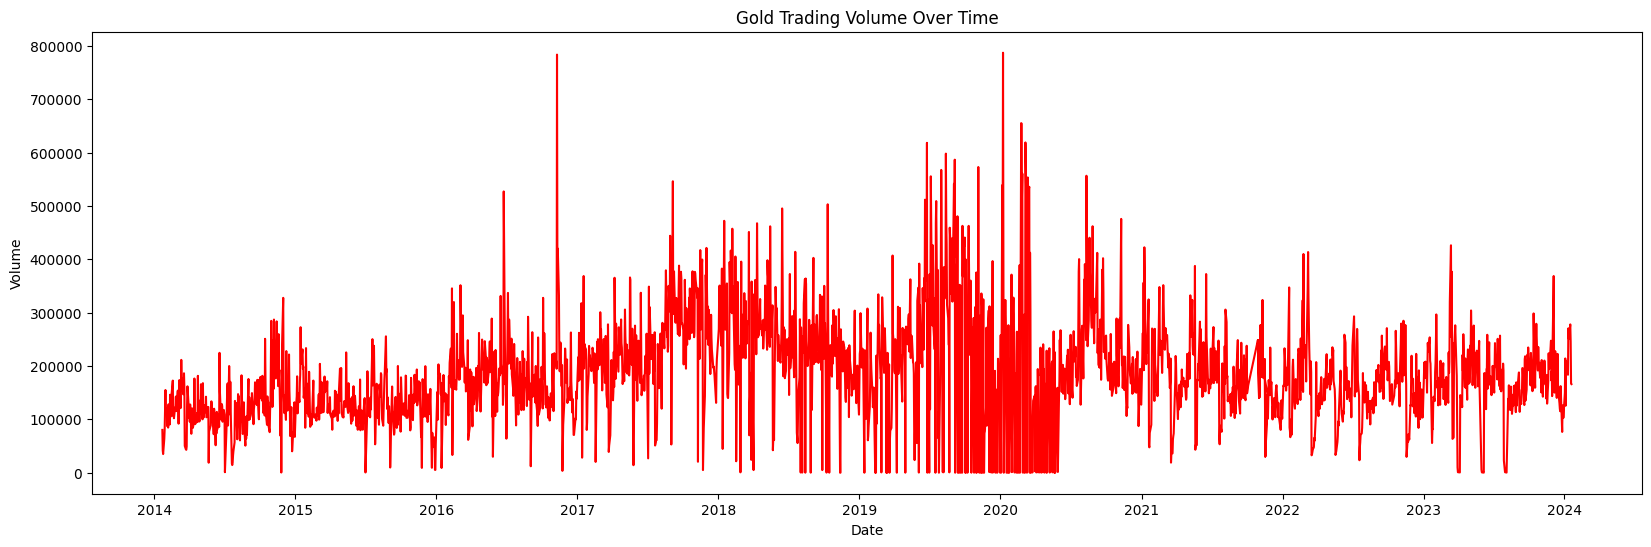

In [19]:
# Analyze the impact on gold prices
# Load trading volume data
volume_df = pd.read_csv('C:/Users/Lenovo/Downloads/goldstock.csv')
volume_df['Date'] = pd.to_datetime(volume_df['Date'])
volume_df.set_index('Date', inplace=True)

# Visualize trading volume
plt.figure(figsize=(20, 6))
plt.plot(volume_df['Volume'], color='r')
plt.title('Gold Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


volume was more btw early starting and middle of 2020

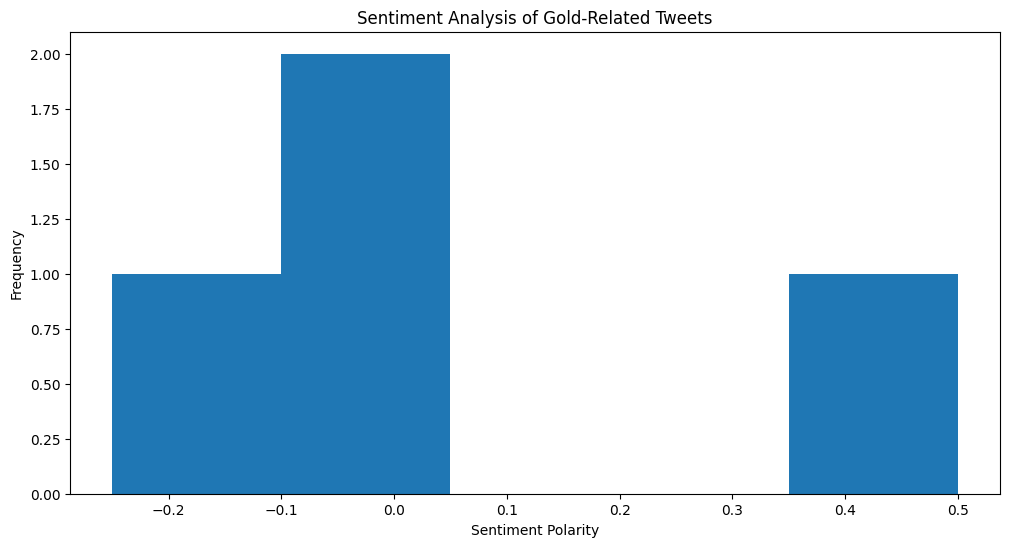

In [14]:
# Perform sentiment analysis on social media platforms (using libraries such as TextBlob or VaderSentiment)
# For example, using TextBlob:

from textblob import TextBlob

tweets = [
    "Gold prices are going up!",
    "I think gold prices will drop soon.",
    "I'm not sure what to make of gold's performance today.",
    "Gold is a safe haven in times of uncertainty.",
]

sentiments = [TextBlob(tweet).sentiment.polarity for tweet in tweets]

plt.figure(figsize=(12, 6))
plt.hist(sentiments, bins=5)
plt.title('Sentiment Analysis of Gold-Related Tweets')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

The sentiment.polarity attribute of a TextBlob object returns a float value between -1 and 1, where -1 indicates a negative sentiment, 0 indicates a neutral sentiment, and 1 indicates a positive sentiment.

Mean: 0.43040353160039346
Standard Deviation: 0.28636781093869385
Skewness: 0.3959399842687725
Kurtosis: -1.439484002213147


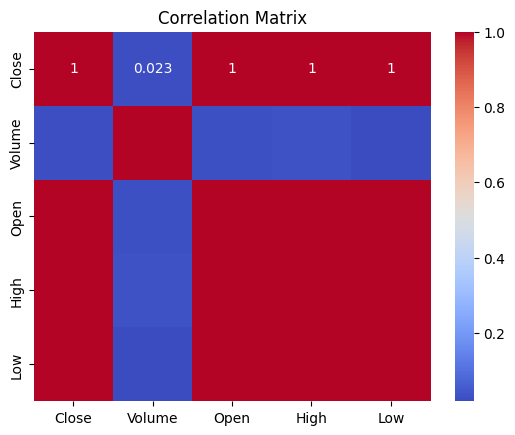

In [15]:
# Perform statistical tests to understand the distribution and variability of gold prices
print('Mean:', df['Close'].mean())
print('Standard Deviation:', df['Close'].std())
print('Skewness:', df['Close'].skew())
print('Kurtosis:', df['Close'].kurt())

# Calculate and analyze correlations between gold prices
correlation_matrix = df.drop(columns=['Unnamed: 0', 'Position', 'CumulativeReturns', 'Buy Signal', 'Sell Signal', '50-day MA']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()